In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 40
display_epochs = (0, 100)


In [3]:
model_name = 'depthwise_(32-64-126)_(NaN).tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,33,seq_001682.jpg
1,33,seq_001816.jpg
2,33,seq_001038.jpg
3,28,seq_000191.jpg
4,48,seq_000989.jpg
...,...,...
1995,28,seq_001922.jpg
1996,30,seq_001836.jpg
1997,18,seq_000048.jpg
1998,23,seq_000460.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

## Custom Depthwise Seperable Convolution

In [12]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride = 1, pooling = False, dropout = False):
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(input)
    
    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x  = layers.Activation("relu")(x)
            if dropout:
                x = layers.Dropout(0.5)(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x  = layers.Activation("relu")(x)
        if dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.SeparableConv2D(size, 3, stride, padding='same', use_bias=False)(x)
        if pooling:
            x = layers.MaxPooling2D()(x)
        
    return x
        

# Output Layer

In [13]:
def basic_dense_block(covnet_param, sizes):
    x = layers.Flatten()(covnet_param)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

In [14]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)

2023-12-13 18:47:08.274058: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-13 18:47:08.274085: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-13 18:47:08.274090: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-13 18:47:08.274122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 18:47:08.274137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 236, 316, 32)      2400      
                                                                 
 batch_normalization (Batch  (None, 236, 316, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 236, 316, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 236, 316, 32)      1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 236, 316, 32)      128   

# Train model

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [17]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/40


2023-12-13 18:47:09.215433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 117.6478 - mae: 7.7016INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 15s 439ms/step - loss: 117.6478 - mae: 7.7016 - val_loss: 1017.7920 - val_mae: 31.1691
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 14.6956 - mae: 3.0621INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 420ms/step - loss: 14.6956 - mae: 3.0621 - val_loss: 1006.9945 - val_mae: 30.9954
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 8.9632 - mae: 2.3306INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 436ms/step - loss: 8.9632 - mae: 2.3306 - val_loss: 1003.8536 - val_mae: 30.9447
Epoch 4/40
32/32 [==============================] - ETA: 0s - loss: 6.2886 - mae: 1.9859INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 15s 460ms/step - loss: 6.2886 - mae: 1.9859 - val_loss: 993.1561 - val_mae: 30.7714
Epoch 5/40
32/32 [==============================] - ETA: 0s - loss: 4.6981 - mae: 1.7358INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 15s 457ms/step - loss: 4.6981 - mae: 1.7358 - val_loss: 984.8897 - val_mae: 30.6368
Epoch 6/40
32/32 [==============================] - ETA: 0s - loss: 3.0909 - mae: 1.3956INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 425ms/step - loss: 3.0909 - mae: 1.3956 - val_loss: 970.2498 - val_mae: 30.3970
Epoch 7/40
32/32 [==============================] - ETA: 0s - loss: 3.8058 - mae: 1.5591INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 420ms/step - loss: 3.8058 - mae: 1.5591 - val_loss: 962.8211 - val_mae: 30.2747
Epoch 8/40
32/32 [==============================] - ETA: 0s - loss: 2.3909 - mae: 1.2210INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 415ms/step - loss: 2.3909 - mae: 1.2210 - val_loss: 950.1124 - val_mae: 30.0646
Epoch 9/40
32/32 [==============================] - ETA: 0s - loss: 1.6189 - mae: 1.0277INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 414ms/step - loss: 1.6189 - mae: 1.0277 - val_loss: 944.2595 - val_mae: 29.9683
Epoch 10/40
32/32 [==============================] - ETA: 0s - loss: 1.3300 - mae: 0.9248INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 410ms/step - loss: 1.3300 - mae: 0.9248 - val_loss: 928.4439 - val_mae: 29.7083
Epoch 11/40
32/32 [==============================] - ETA: 0s - loss: 1.1939 - mae: 0.8761INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 396ms/step - loss: 1.1939 - mae: 0.8761 - val_loss: 905.9467 - val_mae: 29.3392
Epoch 12/40
32/32 [==============================] - ETA: 0s - loss: 2.4524 - mae: 1.2960INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 414ms/step - loss: 2.4524 - mae: 1.2960 - val_loss: 853.6758 - val_mae: 28.4646
Epoch 13/40
32/32 [==============================] - ETA: 0s - loss: 1.3358 - mae: 0.9284INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 414ms/step - loss: 1.3358 - mae: 0.9284 - val_loss: 802.2246 - val_mae: 27.5876
Epoch 14/40
32/32 [==============================] - ETA: 0s - loss: 1.2842 - mae: 0.9014INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 398ms/step - loss: 1.2842 - mae: 0.9014 - val_loss: 710.8516 - val_mae: 25.9494
Epoch 15/40
32/32 [==============================] - ETA: 0s - loss: 1.0090 - mae: 0.8105INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 409ms/step - loss: 1.0090 - mae: 0.8105 - val_loss: 608.8941 - val_mae: 23.9932
Epoch 16/40
32/32 [==============================] - ETA: 0s - loss: 1.3899 - mae: 0.9558INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 398ms/step - loss: 1.3899 - mae: 0.9558 - val_loss: 497.0744 - val_mae: 21.6699
Epoch 17/40
32/32 [==============================] - ETA: 0s - loss: 2.3792 - mae: 1.2733INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 415ms/step - loss: 2.3792 - mae: 1.2733 - val_loss: 410.4672 - val_mae: 19.6546
Epoch 18/40
32/32 [==============================] - ETA: 0s - loss: 1.5677 - mae: 1.0012INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 407ms/step - loss: 1.5677 - mae: 1.0012 - val_loss: 355.0070 - val_mae: 18.2742
Epoch 19/40
32/32 [==============================] - ETA: 0s - loss: 1.2853 - mae: 0.9194INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 441ms/step - loss: 1.2853 - mae: 0.9194 - val_loss: 163.2041 - val_mae: 12.2335
Epoch 20/40
32/32 [==============================] - ETA: 0s - loss: 0.9350 - mae: 0.7664INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 16s 482ms/step - loss: 0.9350 - mae: 0.7664 - val_loss: 161.3388 - val_mae: 12.1671
Epoch 21/40
32/32 [==============================] - ETA: 0s - loss: 0.5613 - mae: 0.5824INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 16s 488ms/step - loss: 0.5613 - mae: 0.5824 - val_loss: 142.2232 - val_mae: 11.4039
Epoch 22/40
32/32 [==============================] - ETA: 0s - loss: 0.5504 - mae: 0.5978INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 15s 431ms/step - loss: 0.5504 - mae: 0.5978 - val_loss: 51.1582 - val_mae: 6.5980
Epoch 23/40
32/32 [==============================] - ETA: 0s - loss: 0.4351 - mae: 0.5284INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 406ms/step - loss: 0.4351 - mae: 0.5284 - val_loss: 31.9333 - val_mae: 5.0475
Epoch 24/40
32/32 [==============================] - ETA: 0s - loss: 1.3283 - mae: 0.9674INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 418ms/step - loss: 1.3283 - mae: 0.9674 - val_loss: 30.4765 - val_mae: 4.9255
Epoch 25/40
32/32 [==============================] - ETA: 0s - loss: 0.7170 - mae: 0.6784INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 15s 425ms/step - loss: 0.7170 - mae: 0.6784 - val_loss: 14.1212 - val_mae: 3.0486
Epoch 26/40
32/32 [==============================] - ETA: 0s - loss: 1.0379 - mae: 0.8349INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 407ms/step - loss: 1.0379 - mae: 0.8349 - val_loss: 11.7329 - val_mae: 2.7259
Epoch 27/40
32/32 [==============================] - ETA: 0s - loss: 0.6116 - mae: 0.6074INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 424ms/step - loss: 0.6116 - mae: 0.6074 - val_loss: 8.5320 - val_mae: 2.2427
Epoch 28/40
32/32 [==============================] - 13s 394ms/step - loss: 0.5666 - mae: 0.6188 - val_loss: 11.9627 - val_mae: 2.7690
Epoch 29/40
32/32 [==============================] - ETA: 0s - loss: 0.7359 - mae: 0.6639INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 412ms/step - loss: 0.7359 - mae: 0.6639 - val_loss: 8.2890 - val_mae: 2.2431
Epoch 30/40
32/32 [==============================] - ETA: 0s - loss: 0.6543 - mae: 0.5965INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 13s 402ms/step - loss: 0.6543 - mae: 0.5965 - val_loss: 8.1311 - val_mae: 2.2245
Epoch 31/40
32/32 [==============================] - ETA: 0s - loss: 0.7339 - mae: 0.6865INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 433ms/step - loss: 0.7339 - mae: 0.6865 - val_loss: 6.5292 - val_mae: 1.9570
Epoch 32/40
32/32 [==============================] - 13s 390ms/step - loss: 0.5098 - mae: 0.5550 - val_loss: 9.6006 - val_mae: 2.4043
Epoch 33/40
32/32 [==============================] - 13s 393ms/step - loss: 0.3671 - mae: 0.4944 - val_loss: 8.0112 - val_mae: 2.1799
Epoch 34/40
32/32 [==============================] - 13s 391ms/step - loss: 1.0299 - mae: 0.8070 - val_loss: 14.6828 - val_mae: 3.0718
Epoch 35/40
32/32 [==============================] - ETA: 0s - loss: 0.8552 - mae: 0.7197INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 14s 427ms/step - loss: 0.8552 - mae: 0.7197 - val_loss: 6.3229 - val_mae: 1.9321
Epoch 36/40
32/32 [==============================] - 13s 406ms/step - loss: 0.5532 - mae: 0.5884 - val_loss: 7.3498 - val_mae: 2.0902
Epoch 37/40
32/32 [==============================] - ETA: 0s - loss: 1.4209 - mae: 1.0051INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)_(NaN).tf/assets


32/32 [==============================] - 15s 455ms/step - loss: 1.4209 - mae: 1.0051 - val_loss: 5.4617 - val_mae: 1.8149
Epoch 38/40
32/32 [==============================] - 15s 427ms/step - loss: 0.6648 - mae: 0.6438 - val_loss: 5.7939 - val_mae: 1.9244
Epoch 39/40
32/32 [==============================] - 14s 452ms/step - loss: 0.4441 - mae: 0.5270 - val_loss: 6.5857 - val_mae: 1.9727
Epoch 40/40
32/32 [==============================] - 13s 392ms/step - loss: 0.2963 - mae: 0.4305 - val_loss: 9.5240 - val_mae: 2.4215


In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 2s 98ms/step - loss: 9.5240 - mae: 2.4215


[9.52403736114502, 2.421529769897461]

In [21]:
model.evaluate(test_generator)

16/16 [==============================] - 2s 105ms/step - loss: 10.3977 - mae: 2.4781


[10.397704124450684, 2.4780876636505127]

# Represent history

In [22]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


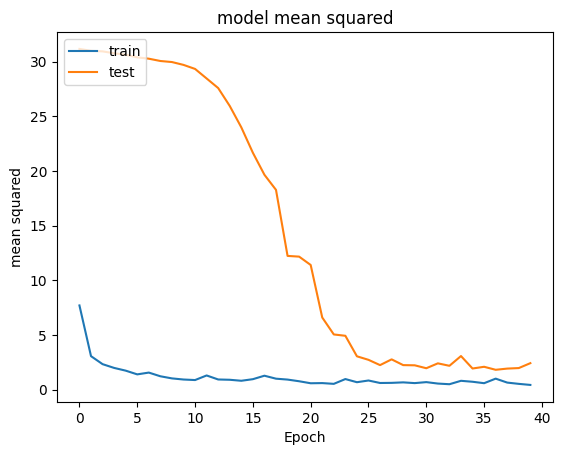

In [23]:
plt.plot(history.history['mae'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_mae'][display_epochs[0]:display_epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

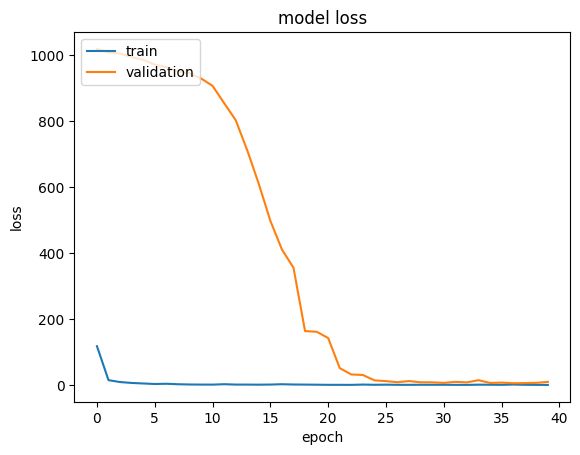

In [24]:
plt.plot(history.history['loss'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_loss'][display_epochs[0]:display_epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Bibliografia

- Deep Learning with Python, Second Edition. François Chollet